In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip show equinox || echo equinox not found. Installing... && pip install equinox 2> /dev/null

Name: equinox
Version: 0.11.2
Summary: Elegant easy-to-use neural networks in JAX.
Home-page: 
Author: 
Author-email: Patrick Kidger <contact@kidger.site>
License: Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by cont

In [2]:
import jax
import equinox as eqx

class FourierEncoding(eqx.Module):
    B: jax.Array

    @property
    def num_fourier_features(self) -> int:
        return self.B.shape[0]

    @property
    def in_size(self) -> int:
        return self.B.shape[1]
    
    @property
    def out_size(self) -> int:
        return self.B.shape[0] * 2

    def __init__(self, 
                 in_size: int, 
                 num_fourier_features: int, 
                 key: jax.random.PRNGKey, 
                 sigma: float = 1.0):
        self.B = jax.random.normal(
            key, shape=(num_fourier_features, in_size),
            dtype=jax.numpy.float32) * sigma
    
    def __call__(self, x: jax.Array, **kwargs) -> jax.Array:
        return jax.numpy.concatenate(
            [jax.numpy.cos(jax.numpy.dot(self.B, x)),
             jax.numpy.sin(jax.numpy.dot(self.B, x))],
            axis=0)

# Solving Parametric Problems using Physics-informed Neural Networks

As you have may have noticed, physics-informed neural networks (PINNs) are not a good choice for solving forward problems.
Standard numerical methods are much faster and more accurate.
One of the places where PINNs can potentially beat traditional approaches is in the solution of \emph{parametric problems}.
In these problems, one has an ODE or PDE that depends on some parameters, and one wants to solve the problem for many different values of the parameters.
PINNs can help us learn, in one shot, the map from the parameters to the solution of the problem.

It is straightforward to extend the standard PINN approach to parametric problems.
Suppose that the parameters are $\boldsymbol{\xi}$, an $\mathbb{R}^d$-valued random vector with PDF $p(\boldsymbol{\xi})$.
The loss function, e.g., from the integrated squared residual, is now dependent on $\boldsymbol{\xi}$:

$$
\boldsymbol{\xi} \mapsto \mathcal{L}_{\boldsymbol{\xi}}(\boldsymbol{\xi}).
$$

The idea, is three-fold. First, try to promote inductive biases by baking in the boundary/initial conditions.
Second, parameterize the uknown part using a neural network $N(\boldsymbol{x}, \boldsymbol{\xi};\theta)$, with parameters $\theta$
A good choice for the parameterization is this structure:

$$
N(\mathbf{x}, \boldsymbol{\xi};\theta) = \sum_{i=1}^m b_i(\boldsymbol{\xi};\theta)\phi_i(\mathbf{x};\theta).
$$

This is a good choice, because it resembles an expansion in a basis of functions $\phi_i(\mathbf{x};\theta)$, with coefficients $b_i(\boldsymbol{\xi};\theta)$.
The difference here is that the basis functions are learned - they are not fixed.
Third, we find the parameters $\theta$, by minimizing the expected loss:

$$
\mathcal{L}(\theta) = \int_{\mathbb{R}^d} \mathcal{L}_{\boldsymbol{\xi}}(\boldsymbol{\xi}) p(\boldsymbol{\xi}) d\boldsymbol{\xi}.
$$

We can do this using Adam, or any other optimization algorithm.
All we need is to express the loss as an expectation and construct an unbiased estimator of the gradient of the loss with respect to the parameters $\theta$.

## Example: Parametric Poisson Equation

Let's consider the following parametric Poisson equation:

\begin{aligned}
    -\Delta u(\mathbf{x};\xi) &= f(\mathbf{x};\xi), \quad \mathbf{x} \in \Omega, \\
    u(\mathbf{x};\xi) &= 0, \quad \mathbf{x}\in \partial\Omega,
\end{aligned}

where $\Omega = [0,1]^2$.
The source term is:

$$
    f(\mathbf{x};\boldsymbol{\xi}) = 2\pi^2\xi\sin(\pi x) \sin(\pi y).
$$

The exact solution to this problem is:

$$
u(\mathbf{x};\boldsymbol{\xi}) = \xi\sin(\pi x) \sin(\pi y).
$$

Let's verify that this is indeed the solution to the problem.

In [3]:
import sympy as sp
from sympy import symbols

x, y, xi = symbols('x y xi')
f = 2 * sp.pi ** 2 * xi * sp.sin(sp.pi * x) * sp.sin(sp.pi * y)
u = xi * sp.sin(sp.pi * x) * sp.sin(sp.pi * y)
res = sp.simplify(sp.diff(u, x, x) + sp.diff(u, y, y) + f)
res

0

I have purposely chosen a simple problem, so that we don't have to deal with non-dimensionalization and scaling.
A parameterization that satisfies the boundary conditions is:

$$
u(x,y;\xi;\theta) = x (1 - x) y (1 - y) N(x,y;\xi;\theta),
$$

where $N(x,y;\xi;\theta)$ is a neural network with parameters $\theta$.
For the neural network, we will use a the structure suggested above.

First, some useful classes to avoid code repetition.

In [4]:
import equinox as eqx

class ParametricModel(eqx.Module):
    """This model captures a simple structure made out of branches and trunks."""
    branch: list  # These are the b's
    trunk: list   # These are the phi's

    def __init__(self, branch, trunk):
        self.branch = branch
        self.trunk = trunk

    def __call__(self, x, xi, **kwargs):
        res = 0.0
        for b, t in zip(self.branch, self.trunk):
            res += b(xi) * t(x)
        return res


class EnforceDirichletZeroBoundarySquare(eqx.Module):
    """This is an model that enforces zero Dirichlet boundary conditions on the square."""
    neural_net: eqx.Module

    def __init__(self, neural_net):
        self.neural_net = neural_net
    
    def __call__(self, x, y, xi, **kwargs):
        return self.neural_net(jnp.array([x, y]), xi) * (1 - x) * x * (1 - y) * y

Let's now make the actual model we will use:

In [5]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

key = jrandom.PRNGKey(0)
key1, key2, key = jrandom.split(key, 3)

# Make the parameterization
m = 10 # number of branches and trunks
# Branches are all MLP's
branch_width = 32
branch_depth = 3
branch = [eqx.nn.MLP('scalar', 'scalar', branch_width, branch_depth, jax.nn.tanh, key=k) for k in jrandom.split(key1, m)]
# Trunks have a FourierEncoding followed by an MLP
trunk_num_fourier_features = 32
trunk_width = 32
trunk_depth = 3
trunk = [eqx.nn.Sequential([
    FourierEncoding(2, trunk_num_fourier_features, key=k),
    eqx.nn.MLP(trunk_num_fourier_features * 2, 'scalar', trunk_width, trunk_depth, jax.nn.tanh, key=k)
]) for k in jrandom.split(key2, m)]
# Combine the branches and trunks into a ParametricModel
model = EnforceDirichletZeroBoundarySquare(ParametricModel(branch, trunk))

Here is how our model looks like as a PyTree:

In [6]:
model

EnforceDirichletZeroBoundarySquare(
  neural_net=ParametricModel(
    branch=[
      MLP(
        layers=(
          Linear(
            weight=f32[32,1],
            bias=f32[32],
            in_features='scalar',
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f32[32,32],
            bias=f32[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f32[32,32],
            bias=f32[32],
            in_features=32,
            out_features=32,
            use_bias=True
          ),
          Linear(
            weight=f32[1,32],
            bias=f32[1],
            in_features=32,
            out_features='scalar',
            use_bias=True
          )
        ),
        activation=<wrapped function <lambda>>,
        final_activation=<function <lambda>>,
        use_bias=True,
        use_final_bias=True,
        in_size='scalar',
        out_size='

Let's ensure our model works:

In [7]:
model(0.5, 0.5, 0.5)

Array(0.00502437, dtype=float32)

Let's create our loss function:

In [8]:
from jax import vmap, grad

def loss_density(model, x, y, xi):
    u_xx = grad(grad(model, 0), 0)(x, y, xi)
    u_yy = grad(grad(model, 1), 1)(x, y, xi)
    f = 2 * jnp.pi ** 2 * xi * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)
    return (u_xx + u_yy + f) ** 2

# This evaluate the loss at multiple xs and ys, but at a single xi
loss_density_single_xi = vmap(loss_density, in_axes=(None, 0, 0, None))

# Τhis evaluates the loss at multiple xs, ys, and xis.
# But the xs and ys are the same for all xis
loss_density_many_xis = vmap(loss_density_single_xi, in_axes=(None, None, None, 0))

# And the final loss
loss = lambda model, xs, ys, xis: jnp.mean(loss_density_many_xis(model, xs, ys, xis))

Let's make sure it works:

In [9]:
xs = jnp.linspace(0, 1, 100)
ys = jnp.linspace(0, 1, 100)
xis = jnp.linspace(0, 1, 20)
res = loss_density_many_xis(model, xs, ys, xis)
res.shape

(20, 100)

And:

In [10]:
loss(model, xs, ys, xis)

Array(48.726887, dtype=float32)

We are not going to worry about the Fourier features. We will let the model learn them.
Here is the training code:

In [11]:
def train_parametric_pinn(
        loss,
        model,
        key,
        optimizer,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=128,
        num_xis = 16,
        num_iter=10_000,
        freq=1,
    ):
    """Notice that it assumes the xi's are sclar and uniformly distributed in [0, 1]."""

    @eqx.filter_jit
    def step(opt_state, model, xs, ys, xis):
        value, grads = eqx.filter_value_and_grad(loss)(model, xs, ys, xis)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    
    losses = []
    for i in range(num_iter):
        key1, key2, key3, key = jrandom.split(key, 4)
        xs = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        ys = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        xis = jrandom.uniform(key3, (num_xis,))
        model, opt_state, value = step(opt_state, model, xs, ys, xis)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return model, losses

Let's train. Be patient. It takes a while to compile the model. Once the iterations start, it is faster. It takes about 2.5 minutes to run on my machine.

In [37]:
import optax

optimizer = optax.adam(1e-3)

model, losses = train_parametric_pinn(
    loss, model, key, optimizer,
    num_collocation_residual=128, num_xis=2,
    num_iter=1_000, freq=1)

Step 0, residual loss 5.746e-02
Step 1, residual loss 4.884e-01
Step 2, residual loss 4.151e-02
Step 3, residual loss 6.356e-02
Step 4, residual loss 4.841e-01
Step 5, residual loss 2.277e-01
Step 6, residual loss 3.806e-02
Step 7, residual loss 1.023e-01
Step 8, residual loss 2.768e-01
Step 9, residual loss 2.563e-01
Step 10, residual loss 1.278e-01
Step 11, residual loss 2.503e-02
Step 12, residual loss 9.534e-02
Step 13, residual loss 1.992e-01
Step 14, residual loss 1.146e-01
Step 15, residual loss 1.077e-01
Step 16, residual loss 6.966e-03
Step 17, residual loss 9.710e-03
Step 18, residual loss 6.682e-02
Step 19, residual loss 1.755e-01
Step 20, residual loss 2.037e-01
Step 21, residual loss 9.842e-02
Step 22, residual loss 1.372e-02
Step 23, residual loss 3.400e-03
Step 24, residual loss 1.113e-02
Step 25, residual loss 5.384e-02
Step 26, residual loss 9.686e-02
Step 27, residual loss 1.681e-02
Step 28, residual loss 4.020e-02
Step 29, residual loss 2.934e-02
Step 30, residual lo

Let's visualize the loss:

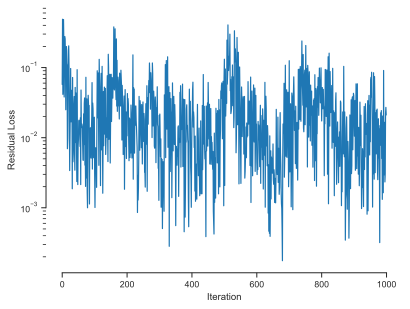

In [38]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residual Loss')
sns.despine(trim=True);

Let's make some predictions are random $\xi$'s:

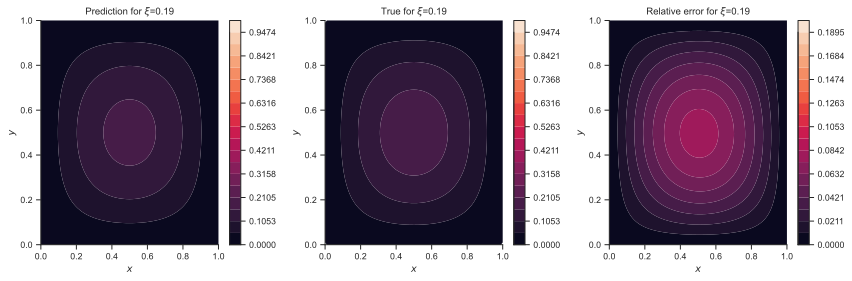

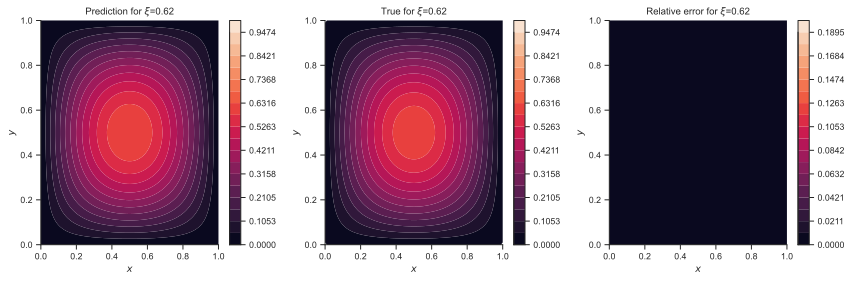

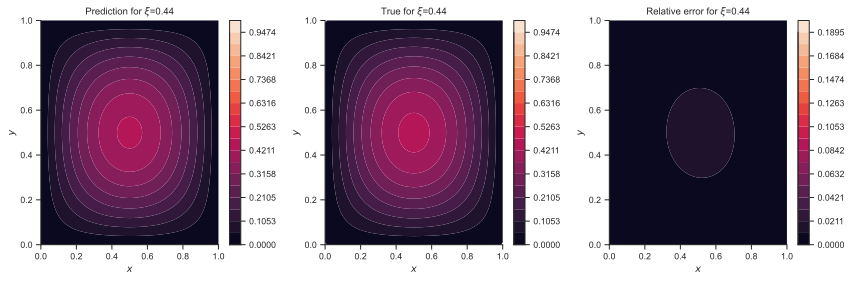

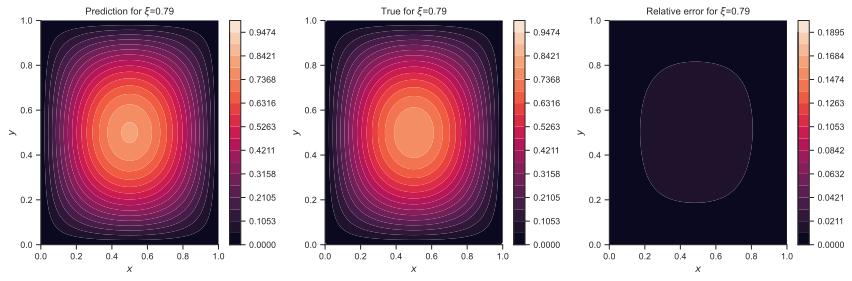

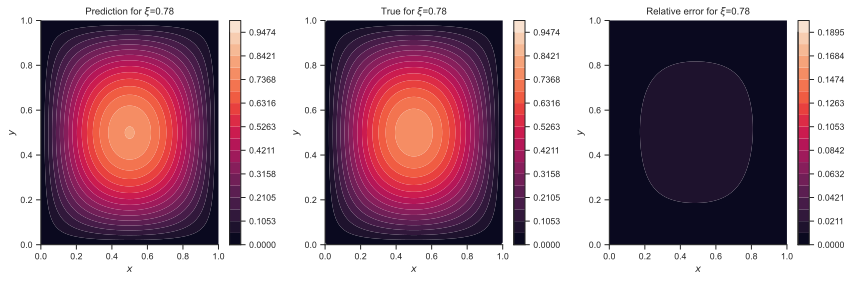

In [39]:
import numpy as np
np.random.seed(1234)

u_true = eqx.filter_jit(vmap(lambda x, y, xi: xi * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y), (0, 0, None)))

u_pred = eqx.filter_jit(vmap(model, (0, 0, None)))

xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
X, Y = np.meshgrid(xs, ys)
X_flat = X.flatten()
Y_flat = Y.flatten()

levels = np.linspace(0, 1.0, 20)
error_levels = np.linspace(0, 0.2, 20)

for xi in np.random.rand(5):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].set_title(f"Prediction for $\\xi$={xi:.2f}")
    u = vmap(lambda x, y: model(x, y, xi))(xs, ys)
    Z_p = u_pred(X_flat, Y_flat, xi).reshape(X.shape)
    c = ax[0].contourf(X, Y, Z_p, levels=levels)
    fig.colorbar(c, ax=ax[0])
    ax[0].set_xlabel('$x$')
    ax[0].set_ylabel('$y$')
    sns.despine(trim=True)
    ax[1].set_title(f"True for $\\xi$={xi:.2f}")
    Z_t = u_true(X_flat, Y_flat, xi).reshape(X.shape)
    c = ax[1].contourf(X, Y, Z_t, levels=levels)
    fig.colorbar(c, ax=ax[1])
    ax[1].set_xlabel('$x$')
    ax[1].set_ylabel('$y$')
    sns.despine(trim=True)
    ax[2].set_title(f"Relative error for $\\xi$={xi:.2f}")
    E = np.abs(Z_p - Z_t) / np.max(Z_t)
    c = ax[2].contourf(X, Y, E, levels=error_levels)
    fig.colorbar(c, ax=ax[2])
    ax[2].set_xlabel('$x$')
    ax[2].set_ylabel('$y$')
    sns.despine(trim=True)
    plt.tight_layout()

Okay, pretty good! We would have to train for more iterations to get a better fit.